In [1]:
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from scipy.stats import spearmanr
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database, drop_database
from utils import make_regression_array

In [2]:
retrain = False

In [3]:
with open('pg_credentials.p', 'rb') as f:
    pg_credentials = pickle.load(f)

In [4]:
host     = 'localhost'
db_name  = 'goodreads_db'
username = pg_credentials['username']
password = pg_credentials['password']
port = '5432'  # default port that postgres listens on
    
con = psycopg2.connect(database = db_name, user = username, host=host, password=password)

In [5]:
query = "SELECT * FROM works_withgenrelang"
all_data = pd.read_sql_query(query, con)

In [6]:
data, mask = make_regression_array(all_data)

Languages: ['English']


In [7]:
ymask = (all_data['pubyear'][mask] < 2019) & (all_data['pubyear'][mask] > 2008)
mask[mask][~ymask.values] = False
data = data[ymask]

In [8]:
correlations = []
for column in data.columns:
    correlations.append(spearmanr(data[column], data['true_score'])[1])

/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/msimet/anaconda3/envs/goodreads/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [9]:
print(np.array(data.columns)[np.argsort(correlations)])

['true_score' 'nprev' 'author_annualviews' 'genre4' 'genre8' 'genre6'
 'genre1' 'genre5' 'genre0' 'review_embed2' 'genre9' 'ya' 'to_read' 'favs'
 'dnf' 'children' 'genre3' 'genre7' 'is_series' 'review_embed9' 'nratings'
 'review_embed0' 'review_embed1' 'rating' 'review_embed4' 'review_embed3'
 'nreviews' 'review_embed8' 'pub_date' 'genre2' 'review_embed6'
 'review_embed7' 'short_stories' 'review_embed5' 'comics']


In [10]:
print(np.array(correlations)[np.argsort(correlations)])

[0.00000000e+00 1.04246959e-25 1.02541525e-13 1.95636523e-13
 6.65453857e-13 4.53561967e-12 8.11430679e-09 1.10475096e-05
 2.91853340e-05 5.26587075e-04 3.44210073e-03 1.03737268e-02
 1.03737268e-02 1.03737268e-02 1.03737268e-02 1.03737268e-02
 1.29833254e-02 1.42113578e-02 2.06501085e-02 2.33234665e-02
 2.43302703e-02 3.38723471e-02 5.17602211e-02 6.37783653e-02
 9.07830362e-02 1.14910484e-01 1.41060206e-01 2.24027814e-01
 2.74883188e-01 3.48372199e-01 5.96913020e-01 5.99983110e-01
 6.31168429e-01 8.51469113e-01            nan]


In [11]:
if retrain:
    cols = [c for c, p in zip(data.columns, correlations) if p<1E-2]
    np.save('columns.npy', cols)
else:
    cols = np.load('columns.npy')

In [12]:
x_train = data.sample(frac=0.8, random_state=100)
x_test = data.drop(x_train.index)
data_train = x_train
data_test = x_test
x_train = x_train[cols]
x_test = x_test[cols]
y_train_continuous = x_train.pop("true_score")
y_test_continuous = x_test.pop("true_score")
thresh = 0
y_train = y_train_continuous > thresh
y_test = y_test_continuous > thresh

In [13]:
if retrain:
    yp_train_list = []
    yp_test_list = []
    model_list = []
    for i in range(10):
        gbm = GradientBoostingClassifier(n_estimators=200)
        gbm.fit(x_train, y_train)
        yp_train_list.append(gbm.predict(x_train))
        yp_test_list.append(gbm.predict(x_test))
        model_list.append(gbm)
        with open(f'gbm_ensemble_{i}.p', 'wb') as f:
            pickle.dump(gbm, f)
else:
    model_list = []
    yp_train_list = []
    yp_test_list = []
    model_list = []
    for i in range(10):
        with open(f'gbm_ensemble_{i}.p', 'rb') as f:
            model_list.append(pickle.load(f))
        yp_train_list.append(model_list[-1].predict(x_train))
        yp_test_list.append(model_list[-1].predict(x_test))


In [14]:
mean_train_prediction = np.mean(yp_train_list, axis=0)
mean_test_prediction = np.mean(yp_test_list, axis=0)

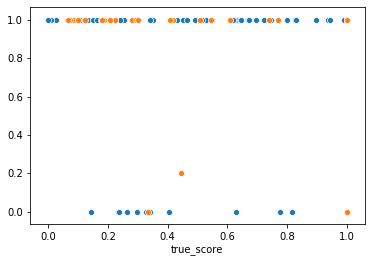

In [15]:
train_mask = y_train==1
test_mask = y_test==1
sns.scatterplot(y_train_continuous[train_mask], mean_train_prediction[train_mask])
sns.scatterplot(y_test_continuous[test_mask], mean_test_prediction[test_mask])

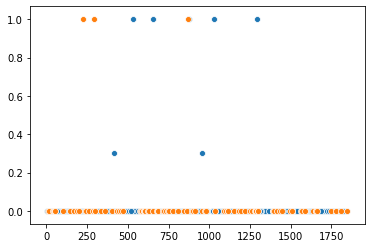

In [16]:
train_mask = y_train==0
test_mask = y_test==0
sns.scatterplot(y_train_continuous.index[train_mask], mean_train_prediction[train_mask])
sns.scatterplot(y_test_continuous.index[test_mask], mean_test_prediction[test_mask])

In [17]:
all_data['prettystring'] = all_data.apply(lambda x: '{} by {}'.format(x.title, x.author), axis=1)
prettystring = all_data.pop('prettystring')

In [18]:
y_train_comp = pd.DataFrame({'continuous': y_train_continuous, 'discrete': y_train, 'prediction': mean_train_prediction})
y_test_comp = pd.DataFrame({'continuous': y_test_continuous, 'discrete': y_test, 'prediction': mean_test_prediction})

In [19]:
prettystring.loc[y_train_comp.index[y_train_comp['discrete']!=y_train_comp['prediction']]]

584                  The Windup Girl by Paolo Bacigalupi
689                          Boneshaker by Cherie Priest
1295                      Luna: New Moon by Ian McDonald
876                              Vengeful by V.E. Schwab
1029                    The Peripheral by William Gibson
657                      Shades of Grey by Jasper Fforde
413                        Tomorrow's Kin by Nancy Kress
583               The Aeronaut's Windlass by Jim Butcher
216                  Palimpsest by Catherynne M. Valente
1148              The Aeronaut's Windlass by Jim Butcher
531                Great North Road by Peter F. Hamilton
443                Unseen Academicals by Terry Pratchett
38              The Golem and the Jinni by Helene Wecker
961                    Who Fears Death by Nnedi Okorafor
551                     Ship Breaker by Paolo Bacigalupi
957     The Rise and Fall of D.O.D.O. by Neal Stephenson
954        The Hundred Thousand Kingdoms by N.K. Jemisin
673              The Wise Man's

In [20]:
y_train_comp.loc[y_train_comp.index[y_train_comp['discrete']!=y_train_comp['prediction']]]

,continuous,discrete,prediction
584,1.000000,True,0.0
689,0.329167,True,0.0
1295,0.000000,False,1.0
876,0.000000,False,1.0
1029,0.000000,False,1.0
657,0.000000,False,1.0
413,0.000000,False,0.3
583,0.264190,True,0.0
216,0.295833,True,0.0
1148,0.264190,True,0.0


In [21]:
prettystring.loc[y_test_comp.index[y_test_comp['discrete']!=y_test_comp['prediction']]]

224                            Wool Omnibus by Hugh Howey
293                     Misheard Lyrics by Mike Ellsworth
450                                Gemina by Amie Kaufman
870                          Hull Zero Three by Greg Bear
905     Julian Comstock: A Story of 22nd-Century Ameri...
1217                         Seveneves by Neal Stephenson
1557                               Reached by Ally Condie
Name: prettystring, dtype: object

In [22]:
y_test_comp.loc[y_test_comp.index[y_test_comp['discrete']!=y_test_comp['prediction']]]

,continuous,discrete,prediction
224,0.000000,False,1.0
293,0.000000,False,1.0
450,1.000000,True,0.0
870,0.000000,False,1.0
905,0.333333,True,0.0
1217,0.444788,True,0.2
1557,1.000000,True,0.0


In [23]:
# Now try a regressor to rank things that were coded "winners"
x_train_regression = x_train[mean_train_prediction>0]
y_train_regression = y_train_continuous[mean_train_prediction>0]
x_test_regression = x_test[mean_test_prediction>0]
y_test_regression = y_test_continuous[mean_test_prediction>0]

In [24]:
if retrain:
    yp_train_regression_list = []
    yp_test_regression_list = []
    regression_model_list = []
    for i in range(10):
        xtr = x_train_regression.sample(frac=1, replace=True)
        ytr = y_train_regression[xtr.index]
        gbm = GradientBoostingRegressor(n_estimators=200)
        gbm.fit(xtr, ytr)
        yp_train_regression_list.append(gbm.predict(x_train_regression))
        yp_test_regression_list.append(gbm.predict(x_test_regression))
        regression_model_list.append(gbm)
        with open(f'gbm_regressor_ensemble_{i}.p', 'wb') as f:
            pickle.dump(gbm, f)
else:
    yp_train_regression_list = []
    yp_test_regression_list = []
    regression_model_list = []
    for i in range(10):
        with open(f'gbm_regressor_ensemble_{i}.p', 'rb') as f:
            regression_model_list.append(pickle.load(f))
        yp_train_regression_list.append(regression_model_list[-1].predict(x_train_regression))
        yp_test_regression_list.append(regression_model_list[-1].predict(x_test_regression))

In [25]:
mean_train_regression_prediction = np.mean(yp_train_regression_list, axis=0)
mean_test_regression_prediction = np.mean(yp_test_regression_list, axis=0)

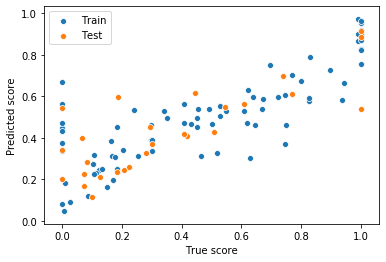

In [64]:
sns.scatterplot(y_train_regression, mean_train_regression_prediction, label="Train")
sns.scatterplot(y_test_regression, mean_test_regression_prediction, label="Test")
plt.xlabel("True score")
plt.ylabel("Predicted score")
plt.legend()

In [27]:
x_train_regression_notselected = x_train[mean_train_prediction==0]
y_train_regression_notselected = y_train_continuous[mean_train_prediction==0]
x_test_regression_notselected = x_test[mean_test_prediction==0]
y_test_regression_notselected = y_test_continuous[mean_test_prediction==0]

In [29]:
yp_train_regression_notselected_list = []
yp_test_regression_notselected_list = []
for model in regression_model_list:
    yp_train_regression_notselected_list.append(model.predict(x_train_regression_notselected))
    yp_test_regression_notselected_list.append(model.predict(x_test_regression_notselected))


In [30]:
mean_train_regression_notselected_prediction = np.mean(yp_train_regression_notselected_list, axis=0)
mean_test_regression_notselected_prediction = np.mean(yp_test_regression_notselected_list, axis=0)

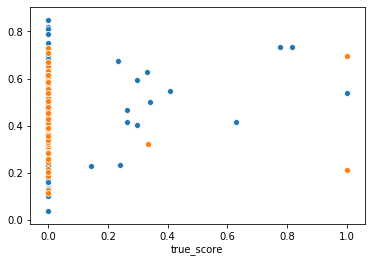

In [31]:
sns.scatterplot(y_train_regression_notselected, mean_train_regression_notselected_prediction)
sns.scatterplot(y_test_regression_notselected, mean_test_regression_notselected_prediction)

In [32]:
query = "SELECT * FROM works_withgenrelang"
all_data = pd.read_sql_query(query, con)

In [33]:
data, mask = make_regression_array(all_data, keep_short_stories = True)
all_data = all_data[mask]

Languages: ['English']


In [34]:
data = data[cols].drop(columns='true_score')

In [35]:
yc_list = []
for model in model_list:
    yc_list.append(model.predict(data))
nominee = np.max(yc_list, axis=0)

ys_list = []
for model in regression_model_list:
    ys_list.append(model.predict(data))
score = np.mean(ys_list, axis=0)
yes_mask = nominee>0
ymin = score[yes_mask].min()
ymax = score[yes_mask].max()
score[yes_mask] = 0.5+0.5*(score[yes_mask]-ymin)/(ymax-ymin)
nmin = score[~yes_mask].min()
nmax = score[~yes_mask].max()
score[~yes_mask] = 0.5*(score[~yes_mask]-nmin)/(nmax-nmin)

In [36]:
print(score[yes_mask].min(), score[yes_mask].max(), score[~yes_mask].min(), score[~yes_mask].max())

0.5 1.0 0.0 0.5


In [37]:
all_data['pred_score'] = score

In [52]:
for idx, row in all_data.iterrows():
    if "Rowling" in row['author']:
        print(idx, row['author'], row['title'], row['pred_score'], row['true_score'])

4 J.K. Rowling Harry Potter and the Chamber of Secrets 0.19077477197168852 0.0
13 J.K. Rowling Harry Potter and the Goblet of Fire 0.20756352992123303 1.0
62 J.K. Rowling Harry Potter and the Deathly Hallows 0.2281301227483583 0.423076923076923
455 J.K. Rowling Harry Potter and the Sorcerer's Stone 0.1841421933645657 0.0
591 J.K. Rowling Harry Potter and the Half-Blood Prince 0.2907894099812206 0.235959595959596
653 J.K. Rowling Fantastic Beasts and Where to Find Them: The Original Screenplay 0.22003139023863252 0.0
880 J.K. Rowling The Tales of Beedle the Bard 0.6601009674658593 0.0
993 J.K. Rowling Harry Potter and the Order of the Phoenix 0.19342610697740373 0.229972247918594
1191 J.K. Rowling Harry Potter and the Prisoner of Azkaban 0.1978129430123162 0.613821138211382
1408 J.K. Rowling Harry Potter Series Box Set 0.22120678051807166 0.0
1504 J.K. Rowling Harry Potter and the Cursed Child: Parts One and Two 0.2296078753248164 0.0


In [61]:
print(y_test_comp[y_test_comp.index==13])

Empty DataFrame
Columns: [continuous, discrete, prediction]
Index: []


In [ ]:
print(cols)
raise RuntimeError()

In [ ]:
def make_datasets_readinglevel(data):
    tdata = data.copy()
    res = []
    for ya in [data['ya'].min(), data['ya'].max()]:
        for children in [data['children'].min(), data['children'].max()]:
            tdata['ya'] = ya
            tdata['children'] = children
            yield tdata

def make_datasets_booktype(data):
    tdata = data.copy()
    res = []
    for ss in [data['short_stories'].min(), data['short_stories'].max()]:
        tdata['short_stories'] = ss
        yield tdata

def make_datasets_author(data):
    tdata = data.copy()
    for aviews in np.linspace(
            data['author_annualviews'].min(), data['author_annualviews'].max(), 10):
        for nprev in range(max(data['nprev'])):
            tdata['author_annualviews'] = aviews
            tdata['nprev'] = nprev
            yield tdata


In [ ]:
# Marginalize over reading level
yc_list = []
for tdata in make_datasets_readinglevel(data):
    for model in model_list:
        yc_list.append(model.predict(tdata))
nominee = np.mean(yc_list, axis=0)>0.1

ys_list = []
for tdata in make_datasets_readinglevel(data):
    for model in regression_model_list:
        ys_list.append(model.predict(tdata))
score = np.mean(ys_list, axis=0)
yes_mask = nominee>0
ymin = score[yes_mask].min()
ymax = score[yes_mask].max()
score[yes_mask] = 0.5+0.5*(score[yes_mask]-ymin)/(ymax-ymin)
nmin = score[~yes_mask].min()
nmax = score[~yes_mask].max()
score[~yes_mask] = 0.5*(score[~yes_mask]-nmin)/(nmax-nmin)

all_data['pred_score_readinglevel'] = score

In [ ]:
# Marginalize over book type
yc_list = []
for tdata in make_datasets_booktype(data):
    for model in model_list:
        yc_list.append(model.predict(tdata))
nominee = np.mean(yc_list, axis=0)>0.1

ys_list = []
for tdata in make_datasets_booktype(data):
    for model in regression_model_list:
        ys_list.append(model.predict(tdata))
score = np.mean(ys_list, axis=0)
yes_mask = nominee>0
ymin = score[yes_mask].min()
ymax = score[yes_mask].max()
score[yes_mask] = 0.5+0.5*(score[yes_mask]-ymin)/(ymax-ymin)
nmin = score[~yes_mask].min()
nmax = score[~yes_mask].max()
score[~yes_mask] = 0.5*(score[~yes_mask]-nmin)/(nmax-nmin)

all_data['pred_score_booktype'] = score

In [ ]:
# Marginalize over authorship
yc_list = []
for tdata in make_datasets_author(data):
    for model in model_list:
        yc_list.append(model.predict(tdata))
nominee = np.mean(yc_list, axis=0)>0.1

ys_list = []
for tdata in make_datasets_author(data):
    for model in regression_model_list:
        ys_list.append(model.predict(tdata))
score = np.mean(ys_list, axis=0)
yes_mask = nominee>0
ymin = score[yes_mask].min()
ymax = score[yes_mask].max()
score[yes_mask] = 0.5+0.5*(score[yes_mask]-ymin)/(ymax-ymin)
nmin = score[~yes_mask].min()
nmax = score[~yes_mask].max()
score[~yes_mask] = 0.5*(score[~yes_mask]-nmin)/(nmax-nmin)

all_data['pred_score_author'] = score

In [ ]:
# Marginalize over reading level and book type
yc_list = []
for ttdata in make_datasets_readinglevel(data):
    for tdata in make_datasets_booktype(ttdata):
        for model in model_list:
            yc_list.append(model.predict(tdata))
nominee = np.mean(yc_list, axis=0)>0.1

ys_list = []
for ttdata in make_datasets_readinglevel(data):
    for tdata in make_datasets_booktype(ttdata):
        for model in regression_model_list:
            ys_list.append(model.predict(tdata))
score = np.mean(ys_list, axis=0)
yes_mask = nominee>0
ymin = score[yes_mask].min()
ymax = score[yes_mask].max()
score[yes_mask] = 0.5+0.5*(score[yes_mask]-ymin)/(ymax-ymin)
nmin = score[~yes_mask].min()
nmax = score[~yes_mask].max()
score[~yes_mask] = 0.5*(score[~yes_mask]-nmin)/(nmax-nmin)

all_data['pred_score_readinglevel_booktype'] = score

In [ ]:
# Marginalize over reading level and authorship
yc_list = []
for ttdata in make_datasets_readinglevel(data):
    for tdata in make_datasets_author(ttdata):
        for model in model_list:
            yc_list.append(model.predict(tdata))
nominee = np.mean(yc_list, axis=0) > 0.2

ys_list = []
for ttdata in make_datasets_readinglevel(data):
    for tdata in make_datasets_author(ttdata):
        for model in regression_model_list:
            ys_list.append(model.predict(tdata))
score = np.mean(ys_list, axis=0)
yes_mask = nominee>0
ymin = score[yes_mask].min()
ymax = score[yes_mask].max()
score[yes_mask] = 0.5+0.5*(score[yes_mask]-ymin)/(ymax-ymin)
nmin = score[~yes_mask].min()
nmax = score[~yes_mask].max()
score[~yes_mask] = 0.5*(score[~yes_mask]-nmin)/(nmax-nmin)

all_data['pred_score_readinglevel_author'] = score

In [ ]:
# Marginalize over book type and authorship
yc_list = []
for ttdata in make_datasets_booktype(data):
    for tdata in make_datasets_author(ttdata):
        for model in model_list:
            yc_list.append(model.predict(tdata))
nominee = np.mean(yc_list, axis=0) > 0.2

ys_list = []
for ttdata in make_datasets_booktype(data):
    for tdata in make_datasets_author(ttdata):
        for model in regression_model_list:
            ys_list.append(model.predict(tdata))
score = np.mean(ys_list, axis=0)
yes_mask = nominee>0
ymin = score[yes_mask].min()
ymax = score[yes_mask].max()
score[yes_mask] = 0.5+0.5*(score[yes_mask]-ymin)/(ymax-ymin)
nmin = score[~yes_mask].min()
nmax = score[~yes_mask].max()
score[~yes_mask] = 0.5*(score[~yes_mask]-nmin)/(nmax-nmin)

all_data['pred_score_booktype_author'] = score

In [ ]:
# Marginalize over all three
yc_list = []
for tttdata in make_datasets_readinglevel(data):
    for ttdata in make_datasets_booktype(tttdata):
        for tdata in make_datasets_author(ttdata):
            for model in model_list:
                yc_list.append(model.predict(tdata))
nominee = np.mean(yc_list, axis=0)>0.3

ys_list = []
for tttdata in make_datasets_readinglevel(data):
    for ttdata in make_datasets_booktype(tttdata):
        for tdata in make_datasets_author(ttdata):
            for model in regression_model_list:
                ys_list.append(model.predict(tdata))
score = np.mean(ys_list, axis=0)
yes_mask = nominee>0
ymin = score[yes_mask].min()
ymax = score[yes_mask].max()
score[yes_mask] = 0.5+0.5*(score[yes_mask]-ymin)/(ymax-ymin)
nmin = score[~yes_mask].min()
nmax = score[~yes_mask].max()
score[~yes_mask] = 0.5*(score[~yes_mask]-nmin)/(nmax-nmin)

all_data['pred_score_readinglevel_booktype_author'] = score

In [ ]:
all_data.columns

In [ ]:
all_data = all_data.drop(columns=['level_0', 'index'])

In [ ]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(username, password, host, port, db_name))

In [ ]:
#all_data.to_sql('works_flask', engine, if_exists='replace') 

In [ ]:
genre_data = all_data[[col for col in all_data.columns if col[:5]=='genre']]

In [ ]:
genre_min = np.min(genre_data, axis=1)

In [ ]:
genre_min.shape

In [ ]:
genre_cutoff = genre_min+0.2

In [ ]:
genre_cutoff[(genre_cutoff>=0.5) & (genre_cutoff<=0.7)] = 0.5

In [ ]:
genre_cutoff[genre_cutoff>=0.7] = genre_min[genre_cutoff>=0.7]

In [ ]:
genre_data = genre_data<=genre_cutoff[:,None]

In [ ]:
np.sum(genre_data, axis=1).value_counts()

In [ ]:
for i in range(10):
    all_data['is_genre{}'.format(i)] = genre_data['genre{}'.format(i)]

In [ ]:
cur = con.cursor()
#cur.execute("drop table works_flask;")
con.commit()

In [ ]:
all_data.to_sql('works_flask', engine, if_exists='replace') 